In [1]:
import pandas as pd
import numpy as np
import datalib_mt5 as dlm
import matplotlib.pyplot as plt
import matplotlib as mlt
import pickle
import time
import sqlite3
import tensorflow as tf
import thread_main_loop as tml
import thread_training
import queue
import threading
import struct
import itertools
import json
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import RMSprop

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
print(tf.__version__)

2.3.0


In [2]:
dlm.insert_db()

continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  n


current in: D:/Workspace/jupyter_workspace/my_advisor/db/WDO-M10_20200810_20200828.sqlite


new will delete currents tables.
new set (y/n)? >>>  n


In [2]:
dataset = dlm.request_table()
#test_dataset = dlm.request_table('temp_test_db', 'market_data_ticks')

In [ ]:
test_dataset = dlm.request_table()

In [3]:
dataset.t_DATE.unique()

array(['2020.09.03', '2020.09.04'], dtype=object)

In [4]:
shift = 10
target = 10
feature_list = ['iBands','iBullsPower','iCCI','iChaikin','iDEMA','iDeMarker','iEnvelopes','iForce','iFrAMA']
x_matrix_size = 60
#feature_list = ['t_LAST','iAD','iRSI','iStochastic','iADX','iOBV','iMACD','iForce','iVolumes','iMFI']
#feature_list = ['t_BID','t_ASK','t_LAST','iAC','iAD','iADX','iADXWilder','iAlligator','iAMA','iAO','iATR','iBearsPower','iBands','iBullsPower','iCCI','iChaikin','iDEMA','iDeMarker','iEnvelopes','iForce','iFractals','iFrAMA','iIchimoku','iBWMFI','iMomentum','iMFI','iMA','iOsMA','iMACD','iOBV','iSAR','iRSI','iRVI','iStdDEV','iStochastic','iTEMA','iTriX','iWPR','iVIDyA','iVolumes']
#feature_list = ['iAO','iATR','iBearsPower','iBands','iBullsPower','iCCI','iChaikin','iDEMA','iDeMarker','iEnvelopes','iForce','iFrAMA','iBWMFI','iOsMA','iMACD']

In [ ]:
test_dataset

In [ ]:
test_dataset = dataset[dataset['t_TIME']<'14:00']
test_dataset = test_dataset.set_index(np.arange(len(test_dataset)))

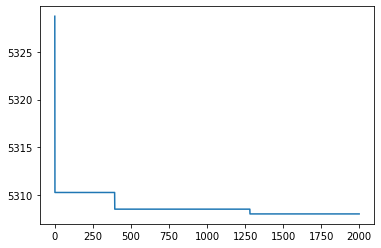

In [291]:
x=dataset.iloc[:2000,27]
plt.plot(np.arange(len(x)),x[:])

## =================================================================

In [5]:
len(feature_list)

9

In [6]:
#ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
x_Mn = dataset
x_Mn['t_DATE-TIME'] = x_Mn['t_DATE'] + x_Mn['t_TIME']
x_Mn = x_Mn.drop_duplicates(subset=['t_DATE-TIME'])
#x_Mn = x_Mn.set_index('t_DATE-TIME')
x_Mn = x_Mn.set_index(np.arange(len(x_Mn)))
x_Mn['t_LAST_Shift'] = x_Mn['t_LAST'].shift(-shift)
x_Mn['t_TIME_Shift'] = x_Mn['t_TIME'].shift(-shift)
x_Mn['t_LAST_DELTA'] = x_Mn['t_LAST'] - x_Mn['t_LAST_Shift']
x_Mn = x_Mn.dropna()

for index, row in x_Mn.iterrows():
    if row['t_LAST_DELTA'] > target:
        x_Mn.loc[index,'t_POS_up'] = 1
        x_Mn.loc[index,'t_POS_down'] = 0
        x_Mn.loc[index,'t_POS_const'] = 0
    elif row['t_LAST_DELTA'] < -target:
        x_Mn.loc[index,'t_POS_down'] = 1
        x_Mn.loc[index,'t_POS_up'] = 0
        x_Mn.loc[index,'t_POS_const'] = 0
    else:
        x_Mn.loc[index,'t_POS_const'] = 1
        x_Mn.loc[index,'t_POS_up'] = 0
        x_Mn.loc[index,'t_POS_down'] = 0

In [8]:
x_Mn=x_Mn[x_Mn['t_TIME']<'14:00']
x_Mn

,t_DATE,t_TIME,t_SEC,t_BID,t_ASK,t_LAST,t_VOLUME,t_TYPE,iAC,iAD,iADX,iADXWilder,iAlligator,iAMA,iAO,iATR,iBearsPower,iBands,iBullsPower,iCCI,iChaikin,iDEMA,iDeMarker,iEnvelopes,iForce,iFractals,iFrAMA,iIchimoku,iBWMFI,iMomentum,iMFI,iMA,iOsMA,iMACD,iOBV,iSAR,iRSI,iRVI,iStdDEV,iStochastic,iTEMA,iTriX,iWPR,iVIDyA,iVolumes,t_DATE-TIME,t_LAST_Shift,t_TIME_Shift,t_LAST_DELTA,t_POS_const,t_POS_up,t_POS_down
0,2020.08.10,09:05,093,5423.5,5424.0,5423.5,1.0,1,3.970588,1.010346e+06,18.239431,18.508609,5424.631021,5429.410395,4.560294,9.071429,-7.376303,5427.525,9.623697,7.299270,-2679.886984,5430.831194,0.623932,5433.14200,-10076.000000,0.0,5427.356992,5430.00,0.501935,99.907894,36.427225,5428.00,0.811465,2.225075,495090.0,5419.945438,47.685062,0.102775,6.193696,51.798561,5431.452674,0.000027,-71.666667,5420.971868,20152.0,2020.08.1009:05,5419.5,09:15,4.0,1.0,0.0,0.0
1,2020.08.10,09:06,071,5421.5,5422.0,5421.5,4.0,1,3.936471,1.000479e+06,18.165860,18.435782,5424.631021,5429.404214,4.517647,9.107143,-7.590588,5427.425,9.909412,-3.261123,-3947.916396,5430.333416,0.618644,5432.99900,-13456.807692,0.0,5427.308224,5430.00,0.511596,99.871051,36.301022,5427.80,0.669648,2.065530,494661.0,5419.945438,46.551581,0.098563,6.273506,49.285714,5430.754600,0.000026,-78.333333,5420.962638,20581.0,2020.08.1009:06,5410.5,09:16,11.0,0.0,1.0,0.0
2,2020.08.10,09:07,030,5428.5,5429.0,5429.0,1.0,0,3.936471,1.041720e+06,18.165860,18.435782,5424.631021,5429.404214,4.517647,9.107143,-8.662017,5427.800,8.837983,27.711797,1375.856331,5432.200083,0.618644,5433.53525,-2072.615385,0.0,5427.491103,5430.00,0.455729,100.009211,34.511246,5428.55,1.201462,2.663821,488298.0,5419.945438,51.107176,0.113963,6.130661,60.000000,5433.372377,0.000030,-53.333333,5420.997643,26944.0,2020.08.1009:07,5408.5,09:17,20.5,0.0,1.0,0.0
3,2020.08.10,09:08,001,5425.0,5425.5,5425.0,5.0,1,3.936471,1.006114e+06,18.165860,18.435782,5424.631021,5429.404214,4.517647,9.107143,-8.090588,5427.600,9.409412,11.460856,-3220.998214,5431.204527,0.618644,5433.24925,-11728.461538,0.0,5427.393567,5430.00,0.460063,99.935525,33.590583,5428.15,0.917828,2.344733,484748.0,5419.945438,48.572070,0.105749,6.153454,54.285714,5431.976229,0.000028,-66.666667,5420.969177,30494.0,2020.08.1009:08,5409.0,09:18,16.0,0.0,1.0,0.0
4,2020.08.10,09:09,013,5419.0,5419.5,5419.5,3.0,0,3.731765,9.701307e+05,17.797412,18.024343,5424.631021,5429.376774,4.261765,9.321429,-10.304874,5427.325,10.195126,-23.956194,-7696.245664,5429.835638,0.588710,5432.85600,-28963.846154,0.0,5427.259456,5430.00,0.515454,99.834208,32.290619,5427.60,0.527831,1.905986,479382.0,5445.000000,45.470734,0.093878,6.382153,48.630137,5430.056526,0.000025,-85.000000,5420.939686,35860.0,2020.08.1009:09,5412.5,09:19,7.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10492,2020.09.10,12:02,108,5298.0,5298.5,5298.0,3.0,1,7.286765,-3.476263e+05,28.252438,18.493285,5297.369210,5292.909365,-3.120588,12.392857,5.450631,5294.225,12.450631,113.510354,7635.810389,5291.086565,0.563025,5293.71700,469.923077,0.0,5293.535679,5289.75,0.231080,100.018879,42.931371,5287.75,2.293146,-1.653431,-862507.0,5273.866200,53.028329,0.070861,11.490730,78.260870,5292.965442,-0.000084,-26.086957,5299.794714,6109.0,2020.09.1012:02,5292.0,12:12,6.0,1.0,0.0,0.0
10493,2020.09.10,12:03,043,5294.0,5294.5,5294.0,1.0,1,7.047941,-3.608860e+05,28.252438,18.493285,5297.369210,5292.899761,-3.419118,12.642857,2.522059,5294.025,13.022059,93.526171,6402.628570,5290.091009,0.563025,5293.43100,-2102.769231,0.0,5292.996125,5289.75,0.347619,99.943364,41.032551,5287.35,2.009512,-1.972519,-865510.0,5273.866200,50.317191,0.065260,11.458048,74.396135,5291.569294,-0.000086,-37.681159,5299.686761,9112.0,2020.09.1012:03,5291.0,12:13,3.0,1.0,0.0,0.0
10494,2020.09.10,12:04,223,5295.0,5295.5,5295.5,2.0,0,7.013824,-3.534767e+05,28.252438,18.493285,5297

In [7]:
x_Mn=x_Mn.set_index(np.arange(len(x_Mn)))

In [8]:
len(x_Mn[x_Mn['t_POS_up']==1])

48

In [9]:
y=x_Mn[['t_POS_up','t_POS_down','t_POS_const']]

In [10]:
y.loc[0]

t_POS_up       0.0
t_POS_down     0.0
t_POS_const    1.0
Name: 0, dtype: float64

In [11]:
#y=x_Mn['t_LAST_DELTA']
x=x_Mn[feature_list]

x_matrix = []
y_matrix = y.loc[x_matrix_size:]
y_values_matrix = []

y_matrix = pd.DataFrame(y_matrix)

for index, row in y_matrix.iterrows():
    x_matrix.append(x[index-x_matrix_size:index])
    y_values_matrix.append(row.values)

In [12]:
x_values_matrix = []
for element in x_matrix:
    x_values_matrix.append(element.values)

In [13]:
x_values_matrix = np.array(x_values_matrix)
y_values_matrix = np.array(y_values_matrix)

In [16]:
x_processed=[]
y_processed=[]
aux=0
for i in range(len(y_values_matrix)):
    if np.array_equal(y_values_matrix[i],np.array([1,0,0])):
        x_processed.append(x_values_matrix[i])
        y_processed.append(y_values_matrix[i])
    if np.array_equal(y_values_matrix[i],np.array([0,1,0])):
        x_processed.append(x_values_matrix[i])
        y_processed.append(y_values_matrix[i])
    if np.array_equal(y_values_matrix[i],np.array([0,0,1])):
        if aux==8:
            x_processed.append(x_values_matrix[i])
            y_processed.append(y_values_matrix[i])
            aux=0
        else:
            aux+=1

In [14]:
x_processed=x_values_matrix
y_processed=y_values_matrix

In [17]:
up=0
down=0
const=0
for i in range(len(y_processed)):
    if np.array_equal(y_processed[i],np.array([1,0,0])):
        up+=1
    if np.array_equal(y_processed[i],np.array([0,1,0])):
        down+=1
    if np.array_equal(y_processed[i],np.array([0,0,1])):
        const+=1
print(up)
print(down)
print(const)

33
48
36


In [18]:
x_processed=np.array(x_processed)
y_processed=np.array(y_processed)

In [19]:
len(y_processed)

117

## Train test split

In [27]:
split =int(len(x_processed)*0.7)
print(split)

1959


In [29]:
#train_X, test_X, train_y, test_y = train_test_split(x_processed, y_processed, random_state = 0)
train_X, test_X, train_y, test_y = x_processed[:split], x_processed[split:], y_processed[:split], y_processed[split:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1959, 60, 9) (1959, 3) (841, 60, 9) (841, 3)


In [ ]:
train_y=np.squeeze(train_y,axis=-1)
test_y=np.squeeze(test_y,axis=-1)

In [ ]:
print(train_X.shape, train_y_scaled.shape, test_X.shape, test_y_scaled.shape)

In [ ]:
scaler = MinMaxScaler()
test_y_scaled = scaler.fit_transform(test_y.reshape(-1,1))
train_y_scaled = scaler.fit_transform(train_y.reshape(-1,1))

In [ ]:
test_y_scaled = np.squeeze(test_y_scaled,axis=-1)
train_y_scaled = np.squeeze(train_y_scaled,axis=-1)

## Over sampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE('minority')

In [ ]:
train_X_squeeze=train_X.reshape(len(train_X),len(train_X[0]) * len(train_X[0][0]))
print(train_X_squeeze.shape)

In [ ]:
#layer = tf.keras.layers.LayerNormalization(axis=1)
#output = layer(train_X[rand])

In [ ]:
train_X_os, train_y_os = smote.fit_sample(train_X_squeeze, train_y)
print(train_X_os.shape, train_y_os.shape)

In [ ]:
train_X_os, train_y_os = smote.fit_sample(train_X_os, train_y_os)

In [ ]:
print(train_X_os.shape, train_y_os.shape)

In [ ]:
up=0
down=0
const=0
for i in range(len(train_y_os)):
    if np.array_equal(train_y_os[i],np.array([1,0,0])):
        up+=1
    if np.array_equal(train_y_os[i],np.array([0,1,0])):
        down+=1
    if np.array_equal(train_y_os[i],np.array([0,0,1])):
        const+=1
print(up)
print(down)
print(const)

In [ ]:
train_X_os = train_X_os.reshape(len(train_X_os), len(train_X[0]), len(train_X[0][0]))
print(train_X_os.shape, train_y_os.shape)

## Visualize

In [ ]:
x_processed

In [ ]:
ready = False

In [ ]:
#plt.imshow(train_X[index], norm=norm)
#norm = mlt.colors.Normalize(vmin=0.,vmax=1.)
layer = tf.keras.layers.LayerNormalization(axis=1)
fig=plt.figure(figsize=(18,30))
for i in range(5):
    while (not ready):
        rand = random.randint(0, len(train_y)-1)
        if np.array_equal(train_y[rand],[1.0, 0., 0.]):
            plt.subplot(1,5,i+1)
            plt.subplot(1,5,i+1)
            
            output = layer(train_X[rand])
            plt.imshow(output)
            #plt.imshow(train_X[rand], norm=norm)
            plt.title(str(rand)+' / '+str(train_y[rand]))
            ready = True
    ready=False

In [ ]:
#plt.imshow(train_X[index], norm=norm)
#norm = mlt.colors.Normalize(vmin=0.,vmax=1.)
layer = tf.keras.layers.LayerNormalization(axis=1)
fig=plt.figure(figsize=(18,30))
for i in range(5):
    while (not ready):
        rand = random.randint(0, len(train_y)-1)
        if np.array_equal(train_y[rand],[0, 1.0, 0.]):
            plt.subplot(1,5,i+1)
            plt.subplot(1,5,i+1)
            
            output = layer(train_X[rand])
            plt.imshow(output)
            #plt.imshow(train_X[rand], norm=norm)
            plt.title(str(rand)+' / '+str(train_y[rand]))
            ready = True
    ready=False

In [ ]:
#plt.imshow(train_X[index], norm=norm)
#norm = mlt.colors.Normalize(vmin=0.,vmax=1.)
layer = tf.keras.layers.LayerNormalization(axis=1)
fig=plt.figure(figsize=(18,30))
for i in range(5):
    while (not ready):
        rand = random.randint(0, len(train_y)-1)
        if np.array_equal(train_y[rand],[0., 0., 1.]):
            plt.subplot(1,5,i+1)
            plt.subplot(1,5,i+1)
            
            output = layer(train_X[rand])
            plt.imshow(output)
            #plt.imshow(train_X[rand], norm=norm)
            plt.title(str(rand)+' / '+str(train_y[rand]))
            ready = True
    ready=False

In [ ]:
plt.close('all')

In [ ]:
i=0
layer = tf.keras.layers.LayerNormalization(axis=1)
for x in train_X:
    fig=plt.figure(figsize=(18,30))
    output = layer(x)
    plt.imshow(output)
    plt.title(str(i))
    if (train_y[i]==1.0):
        fig.savefig('train/up/'+str(i)+'.png')
    elif (train_y[i]==-1.0):
        fig.savefig('train/down/'+str(i)+'.png')
    elif (train_y[i]==0):
        fig.savefig('train/const/'+str(i)+'.png')
    plt.close(fig)
    i+=1
plt.close('all')

In [ ]:
i=0
for x in test_X:
    fig=plt.figure(figsize=(18,30))
    output = layer(x)
    plt.imshow(output)
    plt.title(str(i))
    if (test_y[i]==1.0):
        fig.savefig('test/up/'+str(i)+'.png')
    elif (test_y[i]==-1.0):
        fig.savefig('test/down/'+str(i)+'.png')
    elif (test_y[i]==0):
        fig.savefig('test/const/'+str(i)+'.png')
    plt.close(fig)
    i+=1
plt.close('all')

In [ ]:
layer3=tf.keras.layers.LayerNormalization()
output = layer3(train_X[837])
plt.imshow(output)

## =================================================================

In [ ]:
#callbacks = myCallback()
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.6):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True
        
#callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [319]:
def variation_calc(a_matrix, Weight):
    line_lenght=(a_matrix.shape)[-2]-1
    variation_matrix=[]
    while line_lenght>0:
        i=0
        variation_line=[]
        for x in a_matrix[line_lenght]:
            var= (((abs(a_matrix[line_lenght][i])/abs(a_matrix[line_lenght-1][i]))-1)) * Weight
            variation_line.append(var)
            i+=1
        variation_matrix.append(variation_line)
        line_lenght-=1
    
    variation_matrix = a_matrix[1:]+(a_matrix[1:]*(variation_matrix))
    return variation_matrix

In [332]:
x_var= variation_calc(x_processed[1],1.2)

In [333]:
x_var=np.array(x_var)

In [354]:
x=[x[8] for x in x_processed[1][1:]]
x_f=[x[8] for x in x_var]

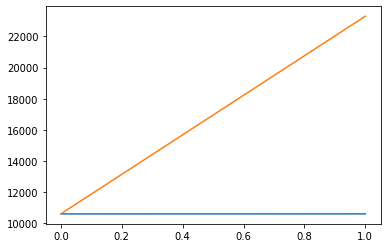

In [357]:
plt.plot(np.arange(2),x[-2:])
plt.plot(np.arange(2),x_f[-2:])

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(train_X[0].shape)))
model.add(tf.keras.layers.LayerNormalization())
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
model.add(tf.keras.layers.SimpleRNN(100, return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(100))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=["accuracy"])
model.summary()

In [30]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LayerNormalization(input_shape=(train_X[0].shape)))

model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.LSTM(32))

model.add(tf.keras.layers.Dense(64,kernel_regularizer=tf.keras.regularizers.L1(0.001),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.Dense(3, activation= 'softmax'))

#model.add(tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1),input_shape=[None]))
#model.add(tf.keras.layers.SimpleRNN(100))
#model.add(tf.keras.layers.Dense(1, activation= 'relu'))
#optimizer = 'adam'
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalCrossentropy(),"accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 60, 9)             18        
_________________________________________________________________
dropout (Dropout)            (None, 60, 9)             0         
_________________________________________________________________
flatten (Flatten)            (None, 540)               0         
_________________________________________________________________
lambda (Lambda)              (None, 540, 1)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 540, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [ ]:
#KeyboardInterrupt
history = model.fit(train_X, train_y, epochs=100,batch_size=72, validation_data=(test_X, test_y),verbose=2,shuffle=False)

Epoch 1/100
28/28 - 51s - loss: 1.3524 - categorical_crossentropy: 1.0995 - accuracy: 0.3155 - val_loss: 1.3527 - val_categorical_crossentropy: 1.1001 - val_accuracy: 0.2925
Epoch 2/100
28/28 - 48s - loss: 1.3510 - categorical_crossentropy: 1.0986 - accuracy: 0.3451 - val_loss: 1.3522 - val_categorical_crossentropy: 1.1001 - val_accuracy: 0.3365
Epoch 3/100
28/28 - 48s - loss: 1.3506 - categorical_crossentropy: 1.0988 - accuracy: 0.3451 - val_loss: 1.3515 - val_categorical_crossentropy: 1.1000 - val_accuracy: 0.3329
Epoch 4/100
28/28 - 49s - loss: 1.3497 - categorical_crossentropy: 1.0984 - accuracy: 0.3425 - val_loss: 1.3509 - val_categorical_crossentropy: 1.1000 - val_accuracy: 0.3329
Epoch 5/100
28/28 - 48s - loss: 1.3497 - categorical_crossentropy: 1.0990 - accuracy: 0.3456 - val_loss: 1.3503 - val_categorical_crossentropy: 1.1000 - val_accuracy: 0.3329
Epoch 6/100
28/28 - 49s - loss: 1.3491 - categorical_crossentropy: 1.0990 - accuracy: 0.3441 - val_loss: 1.3497 - val_categorical_

In [ ]:
# Over-sampling model loss: 0.3165 - categorical_crossentropy: 0.2438 - accuracy: 0.9091 - val_loss: 0.7229 - val_categorical_crossentropy: 0.6535 - val_accuracy: 0.7582
model.save('models/LSTH1609-class-009')

In [ ]:
plt.plot(history.history['accuracy'][:], label='train')
plt.plot(history.history['val_accuracy'][:], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend()
plt.show()

In [ ]:
import os
os.system('shutdown -s')

In [ ]:
# LSTM
t1 = thread_training.thread_training(model, train_X, train_y, 1000, 72, (test_X, test_y), 1, False) 
t1_history = t1.start()

In [ ]:
# RNN
t2 = thread_training.thread_training(model, train_X, train_y, 1000, 72, (test_X, test_y), 1, False) 
t2_history = t2.start()

In [ ]:
loaded_model = tf.keras.models.load_model('models/LSTH1609-class-007')
loaded_model.summary()

In [ ]:
model = loaded_model

In [ ]:
temp_x = train_X_os
temp_y = train_y_os

In [ ]:
x_evaluate = x_processed
y_evaluate = y_processed

In [ ]:
model.evaluate(x_evaluate, y_evaluate, batch_size=144)

In [ ]:
yhat = model.predict(test_X)

In [ ]:
ps = yhat[:100]
ts = test_y[:100]

In [ ]:
plt.figure(figsize=(20, 6))
#dlm.plot_series(np.arange(len(ps)), ps[:])
plt.subplot(211)
plt.plot(np.arange(len(ps)), [x[0] for x in ps[:]])
#plt.subplot(212)
plt.plot(np.arange(len(ts)), [x[0] for x in ts[:]])
plt.grid()

In [ ]:
plt.figure(figsize=(20, 6))
#dlm.plot_series(np.arange(len(ps)), ps[:])
plt.subplot(211)
plt.plot(np.arange(len(ps)),ps)
#plt.subplot(212)
plt.plot(np.arange(len(ts)),ts)
plt.grid(True)

## =================================================================

In [ ]:
score, points = dlm.test_routine(model, test_dataset, shift, target, x_matrix_size, feature_list,1)
print(str(score)+' / '+str(points))

## =================================================================

In [ ]:
t1 = tml.thread_main_loop(model, 60, 9, 0, "0", "1",1) #azul new_dt
t1.start()

In [ ]:
t1.kill()

In [ ]:
t1.join()